<a href="https://colab.research.google.com/github/lubaid-01/spam_project/blob/main/sms_spam_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
!pip install contractions
import contractions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
#this file uses latin-1 encoding rather than UTF-8
df = pd.read_csv("/content/spam.csv", encoding='latin-1')
df.head(4)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN


In [ ]:
df.rename(columns={"v1":"type","v2":"messages"},inplace=True)

In [ ]:
#nothing much in Unnamed: 2, Unnamed: 3, Unnamed: 4 remove them
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace=True)
df.head(4)

,type,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...


In [ ]:
print("duplicate rows no: ",df['messages'].duplicated().sum(),sep=" ")
df.drop_duplicates(inplace=True)
print("current no of rows: ",df.shape[0],sep=" ")

duplicate rows no:  403
current no of rows:  5169


In [ ]:
df['messages'].isnull().sum()
#no null rows

0

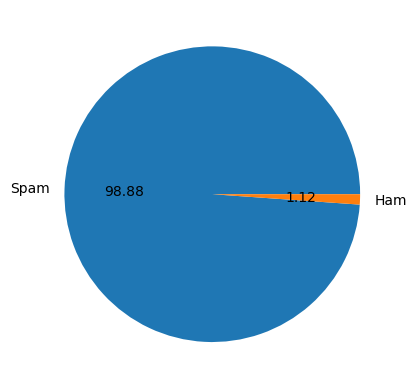

In [ ]:
def check_url(s):
  Match = re.search(re.compile(r"https?://\S+|www\.\S+"),s)
  if Match:
    return True
  else:
    return False
links = df['messages'].apply(check_url)
plt.pie(df['type'][links].value_counts(),labels=["Spam","Ham"],autopct="%0.2f")
plt.show()
#might help in spam detection

**Among all those txts having links in them most are spam**

In [ ]:
df["link"] = links
df.head(4)

,type,messages,link
0,ham,"Go until jurong point, crazy.. Available only ...",False
1,ham,Ok lar... Joking wif u oni...,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,False
3,ham,U dun say so early hor... U c already then say...,False


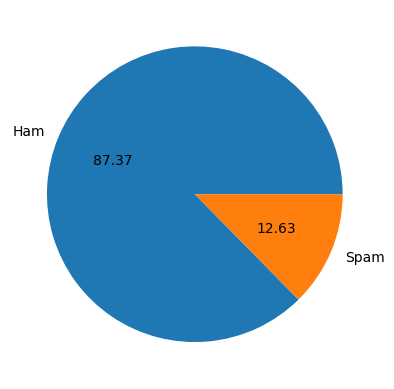

In [ ]:
s = df['type'].value_counts()
plt.pie(s,labels=["Ham","Spam"],autopct="%0.2f")
plt.show()

**Data is imbalanced**

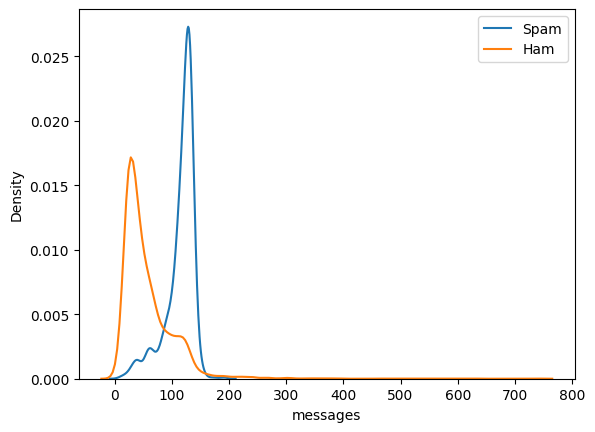

In [ ]:
#lets first understand if there is any relation in raw text and output
n_char = df['messages'].apply(lambda x: len(re.findall(r"\S",x)))
sns.kdeplot(n_char[df['type'] == "spam"],label = "Spam")
sns.kdeplot(n_char[df['type'] == "ham"],label = "Ham")
plt.legend()
plt.show()
#above code provides total no of characters wihtut white spaces

**From above we conclude that no of characters in a message can help us in descision making**

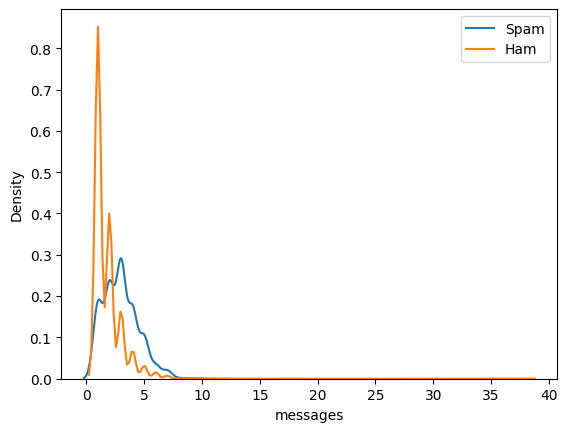

In [ ]:
n_sent = df["messages"].apply(lambda x: len(nltk.sent_tokenize(x)))
sns.kdeplot(n_sent[df["type"]=="spam"],label="Spam")
sns.kdeplot(n_sent[df["type"]=="ham"],label="Ham")
plt.legend()
plt.show()

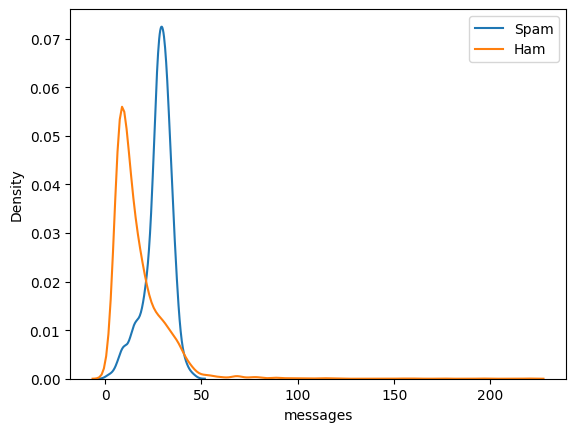

In [ ]:
n_words = df["messages"].apply(lambda x: len(nltk.word_tokenize(x)))
sns.kdeplot(n_words[df["type"]=="spam"],label="Spam")
sns.kdeplot(n_words[df["type"]=="ham"],label="Ham")
plt.legend()
plt.show()

**We can clearly see that no of words in a message and words clearly help us in descisonion making  but lets see the corelation between the two because if they are corelated then we can have only single column**

<Axes: >

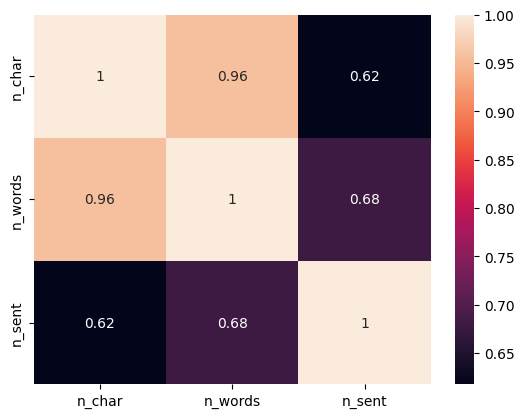

In [ ]:
temp_df = pd.DataFrame({"n_char":n_char,"n_words":n_words,"n_sent":n_sent})
sns.heatmap(temp_df.corr(),annot=True)

**they all are highly corelated as usual especially no of words and no of char therefore we only have n_char**

In [ ]:
df["n_char"] = n_char
df.head(4)

,type,messages,link,n_char
0,ham,"Go until jurong point, crazy.. Available only ...",False,92
1,ham,Ok lar... Joking wif u oni...,False,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,False,128
3,ham,U dun say so early hor... U c already then say...,False,39


**text processing**

In [ ]:
#remove links
def rmv_links(x):
  return re.sub(re.compile(r"https?://\S+|www\.\S+"),"",x)

df['t_messages'] = df['messages'].apply(rmv_links)
df.head(4)

,type,messages,link,n_char,t_messages
0,ham,"Go until jurong point, crazy.. Available only ...",False,92,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,False,24,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,False,128,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,False,39,U dun say so early hor... U c already then say...


In [ ]:
#lower
df['t_messages'] = df["t_messages"].str.lower()
df.head(4)

,type,messages,link,n_char,t_messages
0,ham,"Go until jurong point, crazy.. Available only ...",False,92,"go until jurong point, crazy.. available only ..."
1,ham,Ok lar... Joking wif u oni...,False,24,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,False,128,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,False,39,u dun say so early hor... u c already then say...


In [ ]:
#expanding contractions
temp = df["t_messages"].apply(lambda x: contractions.fix(x))

In [ ]:
#tokenise
df['t_messages'] = df["t_messages"].apply(lambda x : nltk.word_tokenize(x))
df.head(4)

,type,messages,link,n_char,t_messages
0,ham,"Go until jurong point, crazy.. Available only ...",False,92,"[go, until, jurong, point, ,, crazy, .., avail..."
1,ham,Ok lar... Joking wif u oni...,False,24,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,False,128,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,False,39,"[u, dun, say, so, early, hor, ..., u, c, alrea..."


In [ ]:
#find stop words
stpwords = stopwords.words("english")
def find_stp(li):
  num = 0
  for i in li:
    if i in stpwords:
      num +=1
  return num

n_stpwords = df["t_messages"].apply(find_stp)
n_stpwords


,t_messages
0,4
1,0
2,6
3,2
4,6
...,...
5567,10
5568,2
5569,7
5570,13


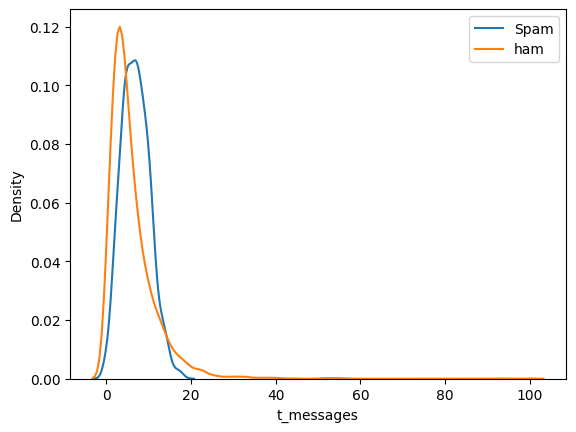

In [ ]:
sns.kdeplot(n_stpwords[df['type'] == "spam"], label="Spam")
sns.kdeplot(n_stpwords[df['type'] == "ham"], label="ham")
plt.legend()
plt.show()

**No big differece between the two therefore stopwords are not good feature to chose**

In [ ]:
lemmatizer= WordNetLemmatizer()

def lemmatize_words(text):
    lemma = None
    tag = pos_tag([text])[0][1]
    if tag.startswith('NN'):
      lemma = lemmatizer.lemmatize(text, pos='n')
    elif tag.startswith('VB'):
      lemma = lemmatizer.lemmatize(text, pos='v')
    elif tag.startswith('JJ'):
      lemma = lemmatizer.lemmatize(text, pos='a')
    elif tag.startswith('RB'):
      lemma = lemmatizer.lemmatize(text, pos='r')
    else:
      lemma = lemmatizer.lemmatize(text)
    return lemma

lemmatize_words("running")

'run'

In [ ]:
def transform(li):
  y = []
  for i in li:
    if i.isalnum() and i not in string.punctuation and i not in stpwords :
          y.append(lemmatize_words(i))

  return y
df["t_messages"] = df["t_messages"].apply(transform)
df.head(4)

,type,messages,link,n_char,t_messages
0,ham,"Go until jurong point, crazy.. Available only ...",False,92,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,False,24,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,False,128,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,False,39,"[u, dun, say, early, hor, u, c, already, say]"


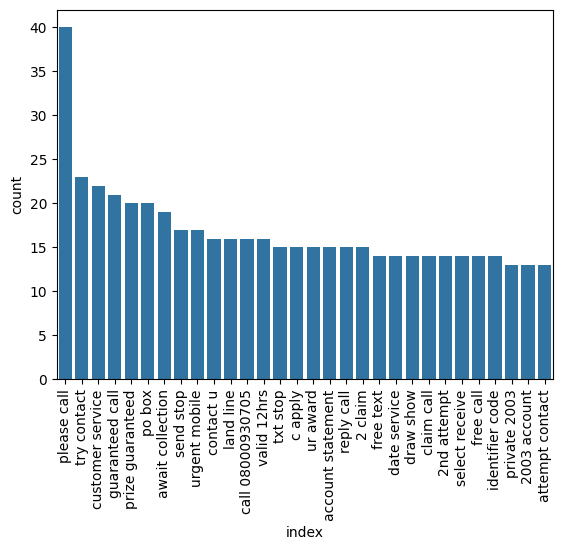

In [ ]:
#from nltk import ngrams
spam_grams_2 = pd.Series(ngrams( df['t_messages'][ df['type'] == "spam" ].sum(),2)).value_counts()
spam_grams_2 = spam_grams_2.to_frame().reset_index()
spam_grams_2["index"]=spam_grams_2['index'].apply(lambda x: " ".join(x))
sns.barplot(data = spam_grams_2.head(30),x=spam_grams_2.head(30)["index"],y=spam_grams_2.head(30)["count"])
plt.xticks(rotation = "vertical")
plt.show()

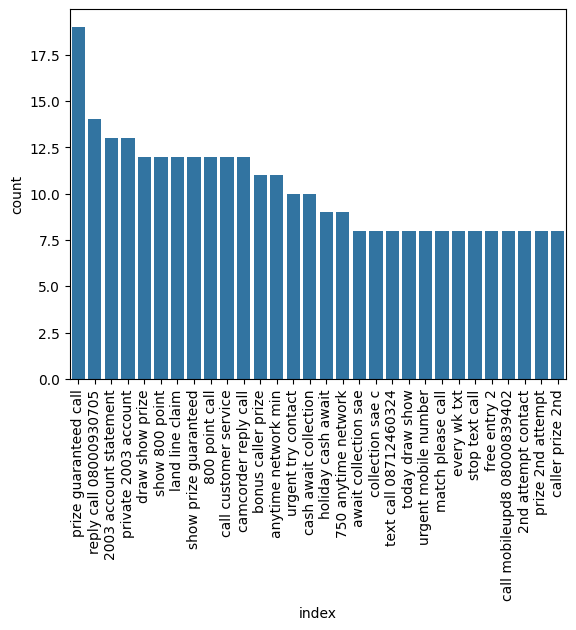

In [ ]:
spam_grams_3 = pd.Series(ngrams( df['t_messages'][ df['type'] == "spam" ].sum(),3)).value_counts()
spam_grams_3 = spam_grams_3.to_frame().reset_index()
spam_grams_3["index"]=spam_grams_3['index'].apply(lambda x: " ".join(x))
sns.barplot(data = spam_grams_3.head(30),x=spam_grams_3.head(30)["index"],y=spam_grams_3.head(30)["count"])
plt.xticks(rotation = "vertical")
plt.show()

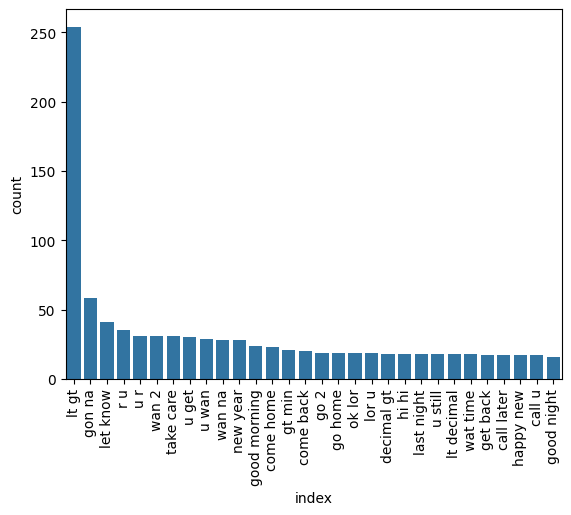

In [ ]:
ham_grams_2 = pd.Series(ngrams( df['t_messages'][ df['type'] == "ham" ].sum(),2)).value_counts()
ham_grams_2 = ham_grams_2.to_frame().reset_index()
ham_grams_2["index"]=ham_grams_2['index'].apply(lambda x: " ".join(x))
sns.barplot(data = ham_grams_2.head(30),x=ham_grams_2.head(30)["index"],y=ham_grams_2.head(30)["count"])
plt.xticks(rotation = "vertical")
plt.show()

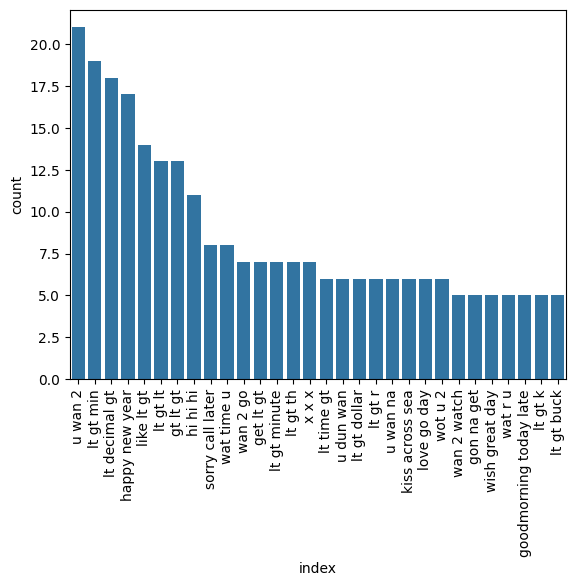

In [ ]:
ham_grams_3 = pd.Series(ngrams( df['t_messages'][ df['type'] == "ham" ].sum(),3)).value_counts()
ham_grams_3 = ham_grams_3.to_frame().reset_index()
ham_grams_3["index"]=ham_grams_3['index'].apply(lambda x: " ".join(x))
sns.barplot(data = ham_grams_3.head(30),x=ham_grams_3.head(30)["index"],y=ham_grams_3.head(30)["count"])
plt.xticks(rotation = "vertical")
plt.show()

In [ ]:
wc = WordCloud(min_font_size= 7, background_color="black")

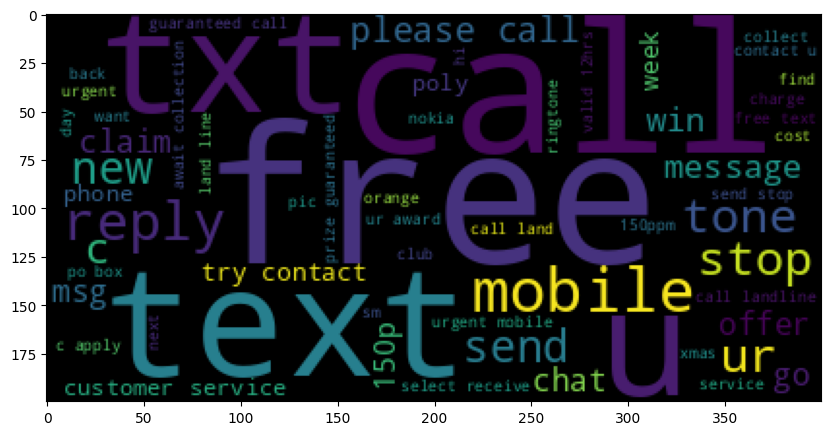

In [ ]:
spam_wc = wc.generate(df['t_messages'][df['type'] == "spam"].str.cat(sep = " "))
plt.figure(figsize = (10,10))
plt.imshow(spam_wc)

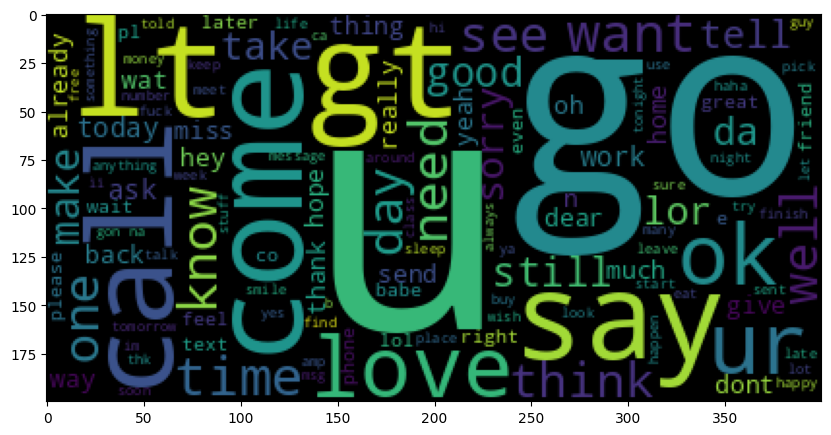

In [ ]:
spam_wc = wc.generate(df['t_messages'][df['type'] == "ham"].str.cat(sep = " "))
plt.figure(figsize = (10,10))
plt.imshow(spam_wc)

**u and n are most frequent stop words and many more we dont remove them so that our model become robust**

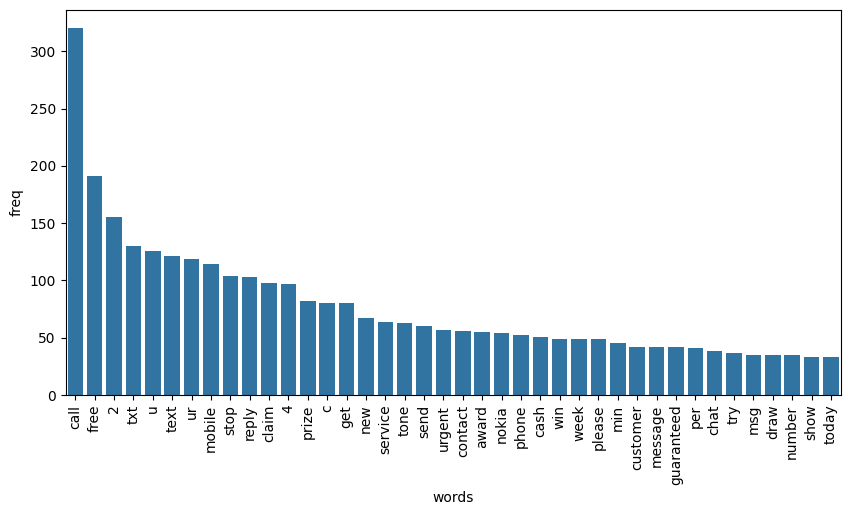

In [ ]:
#finding top words with ferquency manually
spam_corpus = []
for sent in df['t_messages'][df['type'] == "spam"].tolist():
  for word in sent.split():
    spam_corpus.append(word)
spam_wf = pd.DataFrame(Counter(spam_corpus).most_common(40),columns=["words","freq"])
plt.figure(figsize=(10,5))
sns.barplot(data=spam_wf,x=spam_wf['words'],y=spam_wf['freq'])
plt.xticks(rotation = "vertical")
plt.show()

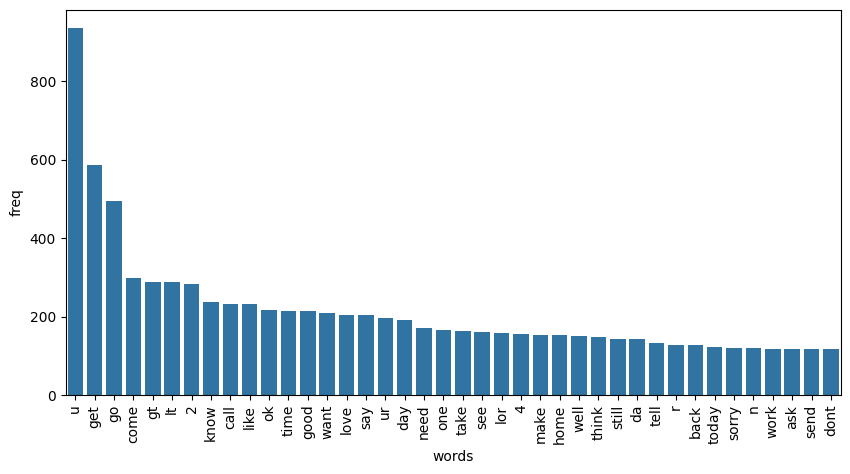

In [ ]:
ham_corpus = []
for sent in df['t_messages'][df['type'] == "ham"].tolist():
  for word in sent.split():
    ham_corpus.append(word)
ham_wf = pd.DataFrame(Counter(ham_corpus).most_common(40),columns=["words","freq"])
plt.figure(figsize=(10,5))
sns.barplot(data=ham_wf,x=ham_wf['words'],y=ham_wf['freq'])
plt.xticks(rotation = "vertical")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.model_selection import cross_validate

In [ ]:
tf = TfidfVectorizer(ngram_range=(1,2))
tf.fit_transform(df['t_messages'].apply(lambda x: " ".join(x))).toarray().shape

(5169, 36004)

Lets finetune no of columns

In [ ]:
le = LabelEncoder()
y = le.fit_transform(df["type"])
y[0:4:1]
# spam ->1
# ham -> 0

array([0, 0, 1, 0])

In [ ]:
features = pd.DataFrame({"n_features" : np.arange(1000,35000,250)})
def make_model(n):
    tf = TfidfVectorizer(max_features = n, ngram_range=(1,2) )
    X = tf.fit_transform(df['t_messages'].apply(lambda x: " ".join(x))).toarray()
    X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=22)
    nb = MultinomialNB()
    nb.fit(X_train,y_train)
    y_pred1 = nb.predict(X_test)
    return (accuracy_score(y_test,y_pred1),precision_score(y_test,y_pred1))
op = features['n_features'].apply(make_model)
features["acc_scr"] = op.apply(lambda x: x[0])
features["prec_scr"] = op.apply(lambda x: x[1])
features.sort_values(by=["prec_scr","acc_scr"], ascending=False)

,n_features,acc_scr,prec_scr
4,2000,0.976789,1.000000
5,2250,0.976789,1.000000
6,2500,0.975822,1.000000
7,2750,0.974855,1.000000
8,3000,0.971954,1.000000
...,...,...,...
135,34750,0.936170,1.000000
1,1250,0.979691,0.990566
2,1500,0.977756,0.990385
3,1750,0.976789,0.990291


In [ ]:
# 2000 has highest precession score therefore we choose max_feature = 2000
tf = TfidfVectorizer(max_features=2000,ngram_range=(1,2))
X = tf.fit_transform(df['t_messages'].apply(lambda x: " ".join(x))).toarray()
X.shape

(5169, 2000)

In [ ]:
li = []
for i in range(3,16):
    nb = MultinomialNB()
    scores = cross_validate(nb,X,y,cv=i,scoring=["accuracy","precision"])
    li.append([i,scores["test_accuracy"].mean(),scores["test_precision"].mean()])

score_frame = pd.DataFrame(li,columns = ["n_folds","acc_scr","prec_scr"])
score_frame.sort_values(by=["prec_scr","acc_scr"],ascending = False)

,n_folds,acc_scr,prec_scr
0,3,0.973496,0.994296
11,14,0.977362,0.989580
9,12,0.976976,0.989323
3,6,0.976784,0.989262
5,8,0.976203,0.989257
7,10,0.976978,0.989185
4,7,0.976783,0.989127
1,4,0.975042,0.989103
12,15,0.977363,0.987990
6,9,0.976397,0.987748


In [ ]:
#checking scores for different random states
li = []
for i in range(0,101,5):
  X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state= i)
  nb = MultinomialNB()
  nb.fit(X_train,y_train)
  y_pred = nb.predict(X_test)
  li.append([i,accuracy_score(y_test,y_pred),precision_score(y_test,y_pred)])
score_frame = pd.DataFrame(li,columns = ["random_state","acc_scr","prec_scr"])
score_frame.sort_values(by=["prec_scr","acc_scr"],ascending = False)

,random_state,acc_scr,prec_scr
14,70,0.982592,1.000000
6,30,0.973888,1.000000
4,20,0.972921,1.000000
2,10,0.968085,1.000000
18,90,0.966151,1.000000
11,55,0.965184,1.000000
0,0,0.970019,0.991667
20,100,0.982592,0.991304
5,25,0.973888,0.991304
10,50,0.978723,0.991228


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state= 70)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
y_pred1 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.9825918762088974
[[903   0]
 [ 18 113]]
1.0


In [ ]:
bnb = BernoulliNB()
bnb.fit(X_train,y_train)
y_pred2 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9777562862669246
[[883   5]
 [ 18 128]]
0.9624060150375939


In [ ]:
#as data is imbalanced  therfore precision score is more important than accuracy score

In [ ]:
#lets try setting alpha
al = pd.DataFrame({"alpha": np.arange(0.5,3.5,0.5)})
def try_alpha(n):
    nb = MultinomialNB(alpha=n)
    nb.fit(X_train,y_train)
    y_pred1 = nb.predict(X_test)
    return (accuracy_score(y_test,y_pred1),precision_score(y_test,y_pred1))
op = al['alpha'].apply(try_alpha)
al["acc_scr"] = op.apply(lambda x: x[0])
al["prec_scr"] = op.apply(lambda x:x[1])
al.sort_values(by=["prec_scr","acc_scr"], ascending=False)

,alpha,acc_scr,prec_scr
1,1.0,0.970019,1.00000
2,1.5,0.962282,1.00000
3,2.0,0.952611,1.00000
4,2.5,0.945841,1.00000
5,3.0,0.940039,1.00000
0,0.5,0.975822,0.99187


alpha = 1 is set correctly

In [ ]:
#lets check that whether the n_char column and is link present helps us or not
Z = X


In [ ]:
Z = np.hstack(  (X,np.array(df["link"]).reshape(df["link"].size,1))  )
Z_train,Z_test,o_train,o_test = train_test_split(Z,y, test_size=0.2, random_state= 40)
z.shape

(5169, 2001)

In [ ]:
md = MultinomialNB()
md.fit(Z_train,o_train)
o_pred = md.predict(Z_test)
print(accuracy_score(o_test,o_pred))
print(confusion_matrix(o_test,o_pred))
print(precision_score(o_test,o_pred))

0.9758220502901354
[[915   1]
 [ 24  94]]
0.9894736842105263


In [ ]:
# having them doesnt help at all

In [ ]:
#save objects as in the state
import pickle
pickle.dump(tf,open("tf.pkl","wb"))
pickle.dump(mnb,open("model.pkl","wb"))
